In [1]:
!git clone https://github.com/mahmoudmhashem/ArSLr

Cloning into 'ArSLr'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 115 (delta 12), reused 44 (delta 10), pack-reused 62
Receiving objects: 100% (115/115), 90.27 MiB | 21.78 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (63/63), done.


In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 11.1 MB/s eta 0:00:00


In [3]:
%cd 'ArSLr/dynamic_words/inference stage/'

/content/ArSLr/dynamic_words/inference stage


In [4]:
import cv2
import torch
import numpy as np
from helper_functions import *

model = torch.jit.load('../assests/model.pt')

In [5]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

  # JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Model:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

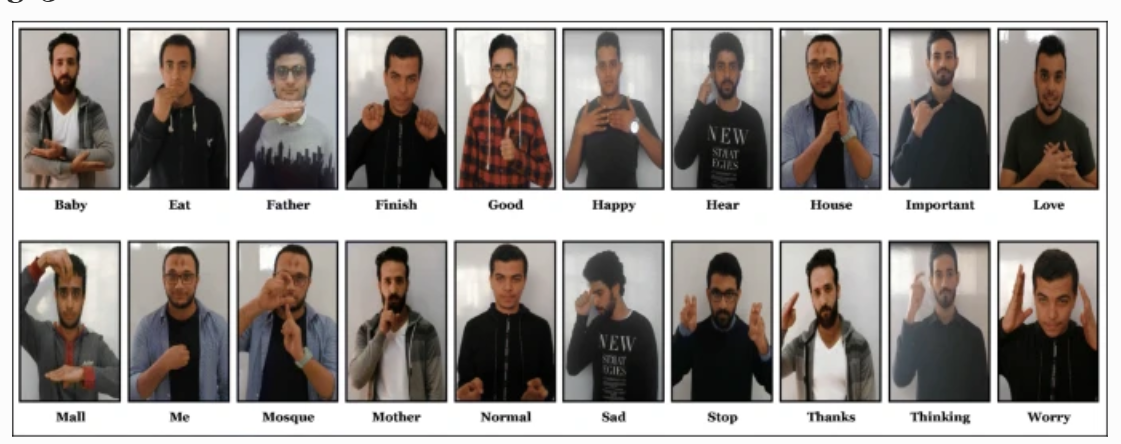

In [ ]:
from time import time
video_stream() # cap = cv2.VideoCapture(0)
overly = ''
label_html = 'Dynamic Words of Arabic Sign Language Recognition'


video_npy_ls = []

potential_label = "None"
current_label = "None"
live = 0
try:
    with PoseLandmarker.create_from_options(pose_options) as poselandmarker:
        with HandLandmarker.create_from_options(hand_options) as handlandmarker:
            while True:
                # ret, frame = cap.read()
                # if not ret:
                #     break
                js_reply = video_frame(label_html, overly)
                if not js_reply:
                    break
                frame = js_to_image(js_reply["img"])

                # frame_timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
                frame_timestamp_ms = int(time()*1e3)
                frame_npy = frame2npy(frame, frame_timestamp_ms, poselandmarker, handlandmarker)
                video_npy_ls.append(frame_npy)

                frame_npy = np.expand_dims(frame_npy, (0, 1))
                frame_npy_tensor = torch.from_numpy(frame_npy)

                frame_npy_tensor = frame_npy_tensor.to(model.device)
                frame_npy_tensor = frame_npy_tensor.to(torch.float32)


                label = model.predict(frame_npy_tensor)['labels'][0]

                # if label == potential_label:
                #     live+=1
                # else:
                #     potential_label = label
                #     live = 0

                # if live > 5:
                #     current_label = potential_label

                # frame = cv2.flip(frame, 1)
                current_label = label

                frame_overlay = np.zeros([480,640,4], dtype=np.uint8)
                cv2.rectangle(frame_overlay, (0,0), (640, 40), (245, 117, 16), -1)
                cv2.putText(frame_overlay, current_label, (3,30),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                frame_overlay[:,:,3] = (frame_overlay.max(axis = 2) > 0 ).astype(int) * 255
                # Show to screen
                # cv2.imshow('OpenCV Feed', frame)
                overly = bbox_to_bytes(frame_overlay)
            #     if cv2.waitKey(1) & 0xFF == ord('q'):
            #         break

            # cap.release()
            # cv2.destroyAllWindows()
except Exception as e:
    print("Error", e)
    # cap.release()
    # cv2.destroyAllWindows()
    raise e

In [ ]:
# video_stream() # cap = cv2.VideoCapture(0)
# overly = ''

# label_html = 'Dynamic Words of Arabic Sign Language Recognition'
# while True:
#   js_reply = video_frame(label_html, overly)
#   if not js_reply:
#       break
#   frame = js_to_image(js_reply["img"])

#   frame_overlay = np.zeros([480,640,4], dtype=np.uint8)
#   cv2.putText(frame_overlay, "Hashem", (3,30),
#             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
#   frame_overlay[:,:,3] = (frame_overlay.max(axis = 2) > 0 ).astype(int) * 255
#   overly = bbox_to_bytes(frame_overlay)